# VCA-K-Hype 端元提取核丰度估计

In [1]:
pip install cupy-cuda11x

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 92.0 MB 1.4 MB/s eta 0:00:01     |███▋                            | 10.4 MB 1.6 MB/s eta 0:00:52     |████████▋                       | 24.8 MB 1.5 MB/s eta 0:00:46     |█████████                       | 26.1 MB 1.5 MB/s eta 0:00:45     |█████████████▋                  | 39.1 MB 1.5 MB/s eta 0:00:36
     |████████████████████████████████| 54 kB 1.8 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print("PyTorch GPU 可用:", torch.cuda.is_available())

PyTorch GPU 可用: True


In [2]:
import cupy
print("CuPy 设备信息:", cupy.cuda.runtime.getDeviceCount())

CuPy 设备信息: 1


In [3]:
import scipy.io
import numpy as np

#  .mat 文件
mat_file_path = '/root/2025_1_14/mydatavca'
data = scipy.io.loadmat(mat_file_path)

#  .mat 文件的结构
print("Keys in the .mat file:", data.keys())


Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'mydatavca'])


In [4]:
# 
if 'mydatavca' in data:
    mydatavca = data['mydatavca']
    print("Shape of 'mydatavca:", mydatavca.shape)
    print("mydatavca (first few elements):", mydatavca[:5])
else:
    print("'mydatavca' key not found in the .mat file.")


Shape of 'mydatavca: (156, 21025)
mydatavca (first few elements): [[18.262968  4.012149 11.184001 ... 10.890511  8.169738 13.371404]
 [12.819861 17.868017 23.349228 ...  1.921394  6.534224 18.585056]
 [24.856802  3.281094 16.439177 ... -2.241089 10.12562   8.475363]
 [18.638134 16.766018  9.203732 ...  4.161026 17.307394 17.924355]
 [ 6.211222 37.167908 20.374807 ... 16.960114  2.938287  9.774576]]


In [5]:
import h5py
import numpy as np

#  .mat 文件
with h5py.File('mydatavca_for_python.mat', 'r') as f:
    mydatavca = np.array(f['mydatavca']).T  # 转置匹配 MATLAB 维度

# 验证维度
print("Python 中 mydatavca 的维度:", mydatavca.shape)  #  (156, 21025)

np.save('mydatavca.npy', mydatavca)

Python 中 mydatavca 的维度: (156, 21025)


In [6]:
import numpy as np
from scipy.io import loadmat
import h5py  # 

def convert_ae_mat_to_npy(mat_path, npy_path, variable_name="Ae"):
    """
    将 MATLAB 的 .mat 文件中的端元矩阵保存为 NumPy .npy 格式
    参数:
        mat_path: 输入的 .mat 文件路径 (e.g. "Ae1_1s.mat")
        npy_path: 输出的 .npy 文件路径 (e.g. "Ae.npy")
        variable_name: 要提取的变量名 (默认为 "Ae")
    """
    try:
        # scipy.io.loadmat 加载 
        data = loadmat(mat_path)
        ae = data[variable_name]
    except NotImplementedError:
        # 
        with h5py.File(mat_path, 'r') as f:
            ae = np.array(f[variable_name]).T  # MATLAB 数据转置
    
    # 保存 .npy
    np.save(npy_path, ae)
    
    # 验证数据
    print("\n[验证报告]")
    print(f"输入文件: {mat_path}")
    print(f"输出文件: {npy_path}")
    print(f"变量名: {variable_name}")
    print(f"矩阵形状: {ae.shape}")
    print(f"数据类型: {ae.dtype}")
    print("前3行、前3列数据片段:")
    print(ae[:3, :3])
    
if __name__ == "__main__":
    # 使用示例
    convert_ae_mat_to_npy(
        mat_path="Ae1_1s.mat",
        npy_path="Ae.npy",
        variable_name="Ae"  # 
    )


[验证报告]
输入文件: Ae1_1s.mat
输出文件: Ae.npy
变量名: Ae
矩阵形状: (156, 3)
数据类型: float64
前3行、前3列数据片段:
[[50.44807388 13.2019994   8.59963482]
 [50.280618   13.66512581  7.92785167]
 [48.17982864 13.25994489  8.42395907]]


# VCA端元提取

提取的端元索引: [6690 7534 9835]
端元矩阵形状: (156, 3)


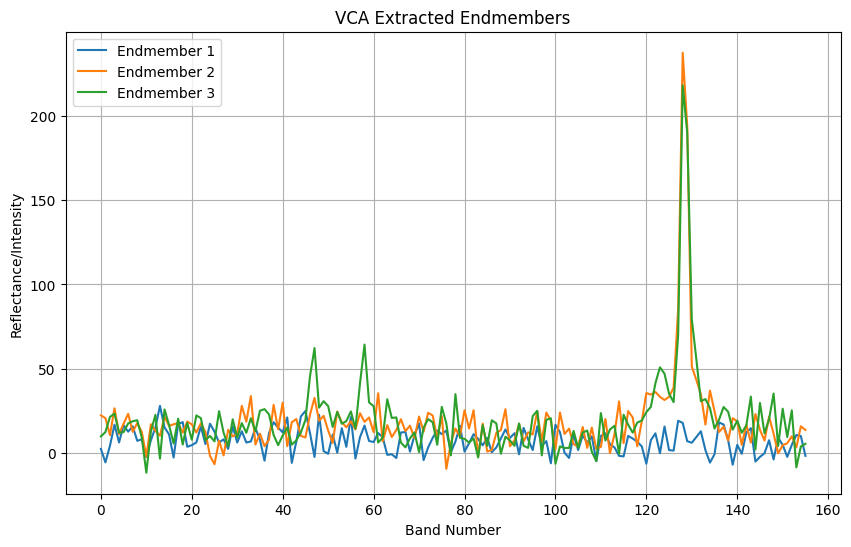

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA

def vca(R, n_endmembers=3, SNR=10, verbose=True):
    L, N = R.shape  # L=波段数, N=像素数

    #  SNR 估计与数据去均值
    if SNR == 0:
        r_m = np.mean(R, axis=1, keepdims=True)
        R_centered = R - r_m
        Ud = np.linalg.svd(R_centered @ R_centered.T / N)[0][:, :n_endmembers]
    else:
        r_m = (np.sum(R, axis=1) / N)
        R_centered = R - r_m.reshape(-1, 1)
        Ud = PCA(n_components=n_endmembers).fit(R_centered.T).components_.T

    #  降维投影
    R_projected = Ud.T @ R_centered
    p = np.mean(R_projected, axis=1)
    R_projected = R_projected / np.linalg.norm(R_projected, axis=0)

    #  迭代寻找端元
    A = np.zeros((n_endmembers, n_endmembers))
    A[-1, 0] = 1
    indices = np.zeros(n_endmembers, dtype=int)
    for i in range(n_endmembers):
        w = np.random.rand(n_endmembers, 1)
        f = w - A @ np.linalg.pinv(A) @ w
        f = f / np.linalg.norm(f)

        v = f.T @ R_projected
        indices[i] = np.argmax(np.abs(v))
        A[:, i] = R_projected[:, indices[i]]

    # 取端元光谱
    Ae = R_centered[:, indices] + r_m.reshape(-1, 1)
    return Ae, indices

# -------------------------------- 主程序 --------------------------------
if __name__ == "__main__":
    # 1. 加载数据
    R = np.load("mydatavca.npy")  #  (bands, pixels)， (156, 20449)

    # 2.  VCA
    Ae, indices = vca(R, n_endmembers=3, SNR=10, verbose=True)
    print(f"提取的端元索引: {indices}")
    print(f"端元矩阵形状: {Ae.shape}")  #  (bands, 3)

    # 3. 绘制端元光谱
    bands = np.arange(Ae.shape[0])  # 波段数从 0 开始编号
    plt.figure(figsize=(10, 6))
    for i in range(Ae.shape[1]):
        plt.plot(bands, Ae[:, i], label=f"Endmember {i+1}")
    plt.xlabel("Band Number")
    plt.ylabel("Reflectance/Intensity")
    plt.title("VCA Extracted Endmembers")
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
pip install scs

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


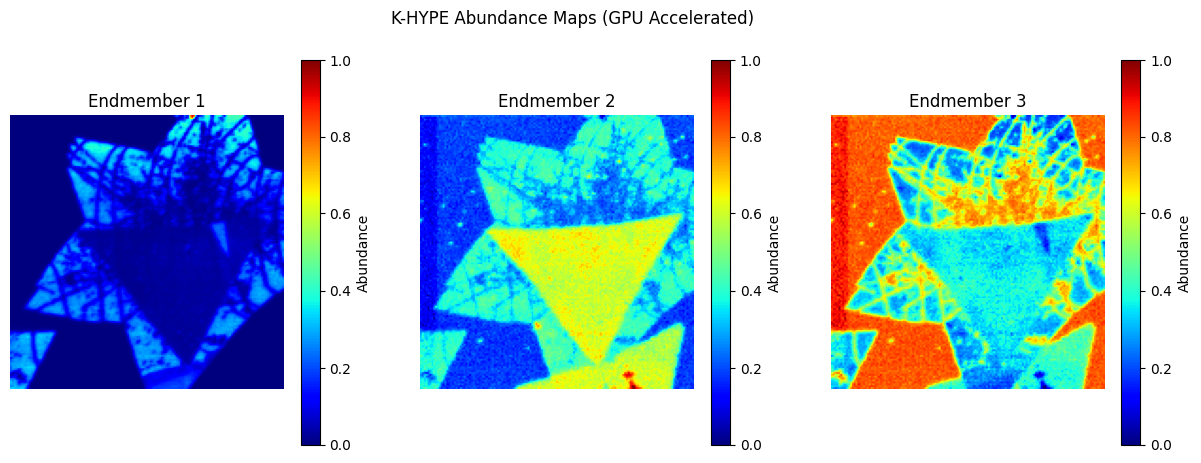

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx  # 使用 cvx 别名
import cupy as cp
from joblib import Parallel, delayed

def rbf_kernel_gpu(X, Y, gamma=1.0):
    X_gpu = cp.asarray(X.T)
    Y_gpu = cp.asarray(Y.T)
    dist = cp.sum((X_gpu[:, None, :] - Y_gpu[None, :, :])**2, axis=2)
    return cp.exp(-gamma * dist).get()

def process_pixel(i, K_A_A, K_A_R):
    n_endmembers = K_A_A.shape[0]
    s = cvx.Variable(n_endmembers)
    objective = cvx.Minimize(-2 * s @ K_A_R[:, i] + cvx.quad_form(s, K_A_A))
    constraints = [s >= 0, cvx.sum(s) == 1]
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver=cvx.SCS)
    return s.value

def khype_abundance_gpu(A, R, gamma=0.1, verbose=False, n_jobs=-1): 
    n_endmembers = A.shape[1]
    n_pixels = R.shape[1]
    
    K_A_A = rbf_kernel_gpu(A, A, gamma) + 1e-6 * np.eye(n_endmembers)
    K_A_R = rbf_kernel_gpu(A, R, gamma)
    

    results = Parallel(n_jobs=n_jobs)( 
        delayed(process_pixel)(i, K_A_A, K_A_R) 
        for i in range(n_pixels)
    )
    S = np.array(results).T
    return S

if __name__ == "__main__":
    R_np = np.load("mydatavca.npy")
    Ae_np = np.load("Ae.npy")
    R = cp.asarray(R_np)
    Ae = cp.asarray(Ae_np)
    
    gamma = 1.0 / (Ae.shape[0] * cp.var(Ae)).get()
    
    S = khype_abundance_gpu(Ae, R, gamma=gamma, n_jobs=-1)
    
    height, width = 145, 145
    abundance_maps = S.reshape(3, height, width)
    plt.figure(figsize=(15, 5))
    titles = ['Endmember 1', 'Endmember 2', 'Endmember 3']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(abundance_maps[i], cmap='jet', vmin=0, vmax=1)
        plt.colorbar(label='Abundance')
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle('K-HYPE Abundance Maps (GPU Accelerated)')
    plt.show()

Reconstruction RMSE: 15.1944


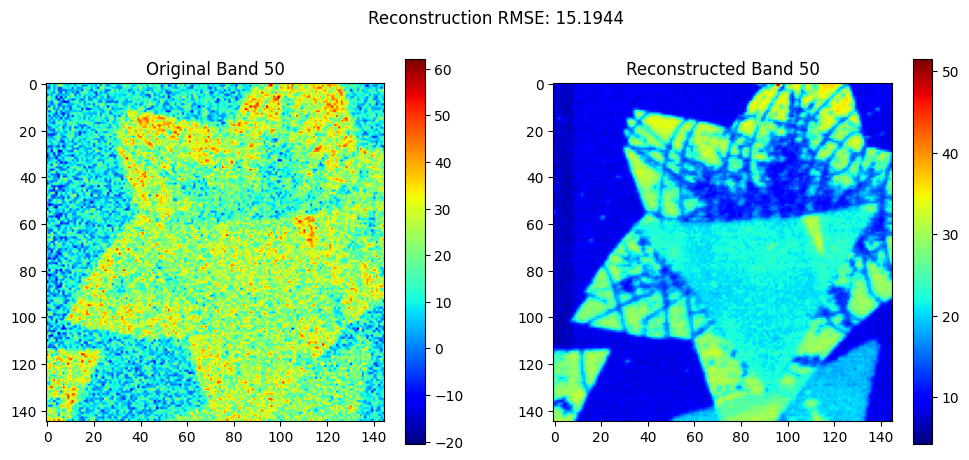

In [7]:
import numpy as np
import cupy as cp

R_original = np.load("mydatavca.npy")  # shape: (bands, pixels)
）
Ae_np = cp.asnumpy(Ae)  
reconstructed_R = np.dot(Ae_np, S)  


# 3. 计算重建RMSE
reconstruction_rmse = np.sqrt(np.mean((R_original - reconstructed_R) ** 2))

print(f"Reconstruction RMSE: {reconstruction_rmse:.4f}")

band_to_show = 50  # 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(R_original[band_to_show].reshape(145, 145), cmap='jet')
plt.title(f'Original Band {band_to_show}')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_R[band_to_show].reshape(145, 145), cmap='jet')
plt.title(f'Reconstructed Band {band_to_show}')
plt.colorbar()
plt.suptitle(f'Reconstruction RMSE: {reconstruction_rmse:.4f}')
plt.show()

端元之间的光谱角距离(SAD)矩阵:
[[0.     1.4334 1.334 ]
 [1.4334 0.     1.2311]
 [1.334  1.2311 0.    ]]


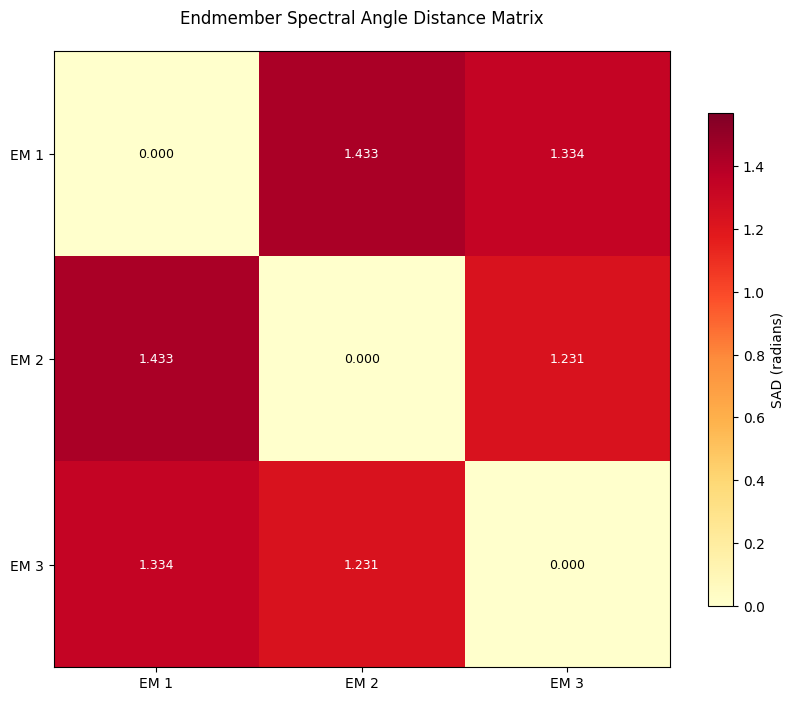


重建误差统计:
-------------------------------
平均SAD: 0.8871 ± 0.1324 radians
最小值: 0.2346 | 最大值: 1.4474
-------------------------------


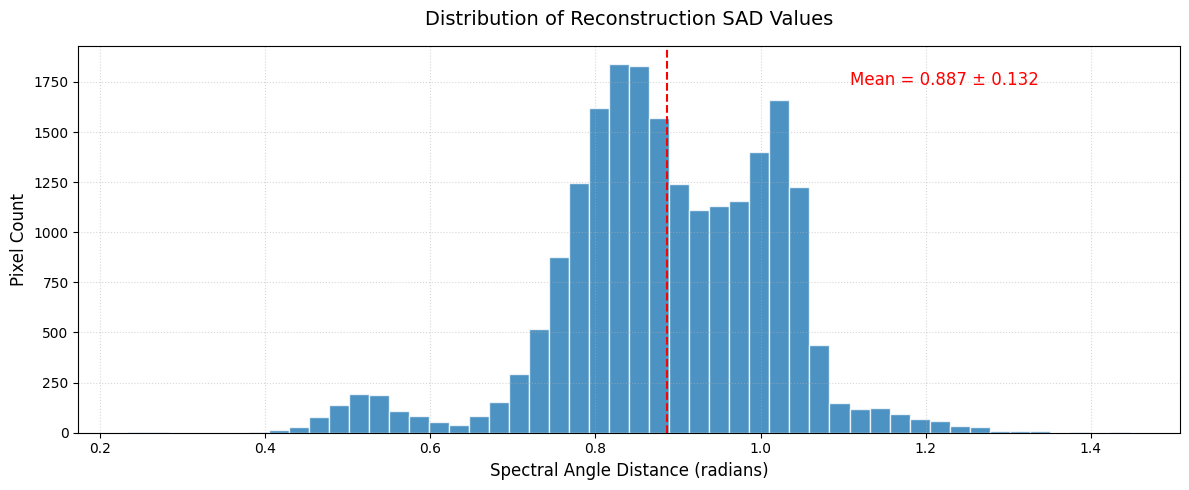